This notebook is an example of using the Particles class in particles.py to read, process, and plot data from .lis files.

In [1]:
from particles import *

100%|██████████| 10001/10001 [00:00<00:00, 11071.82it/s]


[[4.656613e-10]
 [0.000000e+00]
 [0.000000e+00]
 ...
 [4.656613e-10]
 [4.656613e-10]
 [4.656613e-10]]


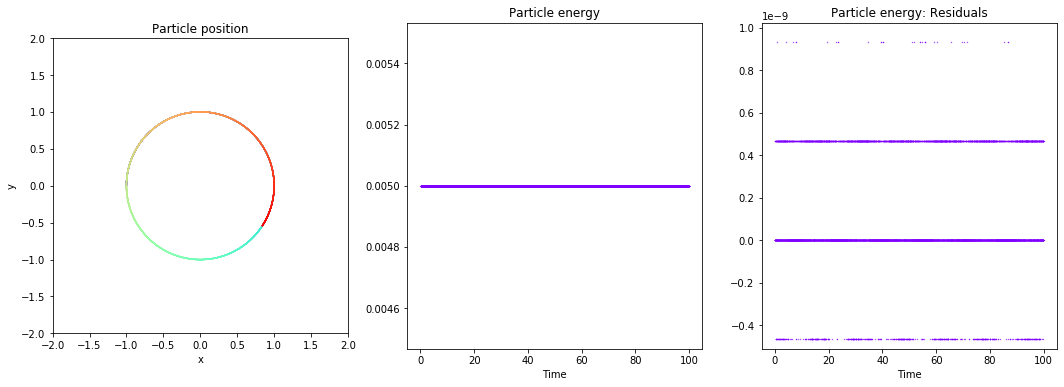

In [2]:
# path to folder containing the .lis files
datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2-particles/bin/test007_Lorentz_VL-SR_gyro/'

filenames = sorted(glob.glob(datapath + '*.lis'))

particles = Particles(relativistic=False)
for filename in tqdm(filenames):
    particles.add_snapshot(filename, verbose=False)
    
fig = plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1,3)

plt.subplot(gs[0,0])
particles.plot_pos2D(plt.gca(), color_by='time')

particles.update_aux_data()

plt.subplot(gs[0,1])
particles.plot_Ekin_vs_time(plt.gca())

plt.subplot(gs[0,2])
particles.plot_Ekin_vs_time(plt.gca(), residuals=True)

plt.show()
plt.close()